In [1]:
import math
import numpy as np
import random
import decimal
import matplotlib.pyplot as plt
import torch
import seaborn as sns

#Now to implement q learning and variants on the above market environment
import sys
if "../" not in sys.path:
  sys.path.append("../") 

#from lib.utes import run_experiment, plot_values, plot_greedy_policy, \
#                        plot_action_values, random_policy, plot_state_value

#from lib.envs.grid import Grid, FeatureGrid, AltGrid
#from TD import  GeneralQ, ExperienceQ, DynaQ #, FeatureExperienceQ, FeatureDynaQ
#from FA.model import TabularModel #, LinearModel
#from Tabular import ExpTabAgent

from lib.envs.market import Market
from lib.graphs import make_baseline_graphs, make_agent_graphs, plot_sample_paths, plot_disc_utility, \
                        plot_mv_equiv, plot_const_step
    
from lib.sim_prices import make_prices, run_stepsim_fixedprop
from lib.execute_strat import execute_strat

%matplotlib inline

In [2]:
"""Important to store and set the different parameters
perhaps pass in a dictionary of parameters each time to avoid silly errors

Experiment 1: Setup
mu 0.11, rf 0.10, sigma 0.028
M=20, T=1.0, utes = 15, S0=1, B0=1, X0=100, wealth = X0, merton 12.75, 
u_star = np.linspace(-10,25, utes)

sims 300,000
kappa 0.008

eps greedy 0.1, learning rate 0.1, gamma 0.95
All the different models
do risk free in build up and log utility based results, also show extreme risk aversion

(do we vary kappa?)


Experiment 2: Higher volatility - can it be learned? Show the problems...perhaps its a trade off
of number of episodes

mu 0.11, rf 0.10, sigma 0.1
M=20, T=1.0, utes = 15, S0=1, B0=1, X0=100, wealth = X0, merton 12.75, 
u_star = np.linspace(-1,1.5, utes)

sims 300,000
kappa 0.007 - trying different values for kappa

eps greedy 0.1, learning rate 0.1, gamma 0.95


Experiment 3: Another utility curve as per experiment 1
One I can parameterise with risk aversion and show the RL learns it...


Experiment 4: Scaling up - alternative RL methods


Experiment 5: Different price processes - maybe trade OU first?
Then see if we can beat merton with a non gbm process?


Chapters ?
Intro
Risk Neutral and Risk Averse
Utilities
Single Period Investing
The Merton Problem - Multi Period Optimality
Stochastic Optimal Control - The solution
Reinforcement Learning
Basic Methods
Problem Setting for RL - myopic investing
RL difficulties
Some examples - vols, means...
Learning Merton Experimental setting - from Myopic to mean variance equivalance
Low Vol results (diff RL algos)
High Vol - trade off with episodes?
Increasing the difference between rf and mu
Different Utility curves - learning increasing risk aversion
Scaling up - RL
Continuous setting
Realistic price processes - beating Merton
Gaussian Processes
Reducing sample numbers with a semi-parametric approach (hypothesising a set of prior kernels
rather than learning purely from the data)
"""

'Important to store and set the different parameters\nperhaps pass in a dictionary of parameters each time to avoid silly errors\n\nExperiment 1: Setup\nmu 0.11, rf 0.10, sigma 0.028\nM=20, T=1.0, utes = 15, S0=1, B0=1, X0=100, wealth = X0, merton 12.75, \nu_star = np.linspace(-10,25, utes)\n\nsims 300,000\nkappa 0.008\n\neps greedy 0.1, learning rate 0.1, gamma 0.95\nAll the different models\ndo risk free in build up and log utility based results, also show extreme risk aversion\n\n(do we vary kappa?)\n\n\nExperiment 2: Higher volatility - can it be learned? Show the problems...perhaps its a trade off\nof number of episodes\n\nmu 0.11, rf 0.10, sigma 0.1\nM=20, T=1.0, utes = 15, S0=1, B0=1, X0=100, wealth = X0, merton 12.75, \nu_star = np.linspace(-1,1.5, utes)\n\nsims 300,000\nkappa 0.007 - trying different values for kappa\n\neps greedy 0.1, learning rate 0.1, gamma 0.95\n\n\nExperiment 3: Another utility curve as per experiment 1\nOne I can parameterise with risk aversion and show 

In [3]:
#Set parameters
mu =0.10 #save these paramters mu 0.11, rf 0.10, sigma 0.028
rf = 0.02
M = 50 #so 20 time periods or 50 still works...just longer to train and run, u_star = np.linspace(-10,25, utes)

time_periods = M
T = 1.0
dt = T/M
utes = 25
#u_star = np.linspace(-10,25, utes) #this is specific to the above parameters

kappa = 0.007


#We will always start with a stock price of 1, bond price of 1, and a time period which will be subdivided
#wealth starts at 100
S0 = 1
B0 = 1
X0 = 100
wealth = X0

lowvol =False

#file = 'LogUteNoisy1epi3000000er8kappa0.0.npy'
if lowvol:
    u_star = np.linspace(-10,25, utes)
    sigma = 0.028
else:
    u_star = np.linspace(0,2, utes)
    sigma = 0.35
    

In [4]:
#From the ritter paper he then instead of calculating the mean variance equivalent
#form at the end, turned this into an incremental reward. He did this for trading an OU
#process showing q learning could find an arbitrage - the step by step is dx - kappa*(dx**2)

#Using the same set up I hoped to be able to approach mertons problem with RL
#the agent won't know the price process, it will have 15 different investment possibilities
#at each time, it will know its wealth level, and have an action of how much to invest.
#each step this order will be executed by the market agent and it will receive a reward. 

#Difficulty one - the agent has no control of much of the next state...it is effectively choosing
#between different probability distributions over wealth, the price process is noisy and independent of
#it, thus the action doesn't control much of the next environment.

#Difficulty two - even a low vol levels, the rewards are noisy and can be misleading. The agent
#does not know that 'the answer' is a constant investment ratio, it must explore.

In [5]:
#The merton ratio leads to a constant ratio for GBM log utility
#note this is a very high leverage because of the low vol
#I did this due to difficulties getting RL to learn anything 
#and we can play around with how to solve this

merton_ratio = (mu-rf)/sigma**2
merton_ratio #the ratio to invest

merton_value = np.log(X0) + (rf + ((mu-rf)/2*sigma**2))

print(merton_ratio, merton_value)

0.653061224489796 4.6300701859880915


In [6]:
print(np.log(X0) + (rf + ((mu-rf)**2/2*sigma**2)))

4.625562185988092


In [7]:
#Ritters paper looks at mean variance equivalence distributions
#he can thus convert with a parameter kappa the above utility to 
#a mean variance trade off...this is possible for all mean variance equiv distn
#and upward sloping utility function (of which log is)

def mv_equiv(kappa, mean, variance):
    return mean - (kappa/2)*variance

merton_ratio = (mu-rf)/sigma**2
best_action = np.argmin(np.abs(u_star-merton_ratio))
print(best_action)
print(u_star[best_action])
u_star

8
0.6666666666666666


array([0.        , 0.08333333, 0.16666667, 0.25      , 0.33333333,
       0.41666667, 0.5       , 0.58333333, 0.66666667, 0.75      ,
       0.83333333, 0.91666667, 1.        , 1.08333333, 1.16666667,
       1.25      , 1.33333333, 1.41666667, 1.5       , 1.58333333,
       1.66666667, 1.75      , 1.83333333, 1.91666667, 2.        ])

In [8]:
num_sims =300000
S, B, utility, means, variances = make_prices(mu, sigma, rf, utes, time_periods, dt, X0, B0,S0, u_star, num_sims)

#if we know the answer is log utility and 
#we know that we have gbm then we can simulate to
#see if our best action is close to the optimal ratio
#according to merton's formula

#we need this to compare the merton strategy to our learned agent
best_action = np.argmax(utility)
utility[best_action]
u_star[best_action] #12.5 is the closest we have to merton which is 12.7

101.97933410959757
87.81063630618543
75.53483957913059
64.90930141800843
55.72114598053409
47.783780271361664
40.93379778233957
35.02822885625152
29.94210105642112
25.566276476408675
21.80553623822475
18.576885432574297
15.8080544770388
13.436175332204892
11.406613244073354
9.671936694393176
8.19101005797888
6.928195105171733
5.8526489645560735
4.937707490676584
4.160344177422422
3.5006958324130113
2.9416471925398473
2.4684675262156195
2.0684930433761957


0.5833333333333333

In [9]:
#this gives mean variance equivalent end of episode values
kappa = 0.008
vals = mv_equiv(kappa, means, variances)

In [10]:
#Run a reward step by step simulation with fixed investment levels to check this looks
#similar to the utility set up

episodes = 200000
kappa = 0.008
mean_rewards, mean_utes, all_wealth = run_stepsim_fixedprop(kappa, mu, sigma, rf,
                                                            u_star, Market, wealth, episodes=200000, time_periods=20)

Inv ratio:  0.0 Mean log utility:  4.624170185988092
Inv ratio:  0.0 Mean Reward:  1.9173902371478204
Min wealth:  101.91816486174086 Max Wealth:  101.91816486174086
Inv ratio:  0.08333333333333333 Mean log utility:  4.631329994549965
Inv ratio:  0.08333333333333333 Mean Reward:  2.6593778850091647
Min wealth:  88.5249034190883 Max Wealth:  121.98674308981023
Inv ratio:  0.16666666666666666 Mean log utility:  4.63725853277149
Inv ratio:  0.16666666666666666 Mean Reward:  3.2980147453489628
Min wealth:  78.97807784072054 Max Wealth:  140.51314315287766
Inv ratio:  0.25 Mean log utility:  4.642058454891014
Inv ratio:  0.25 Mean Reward:  3.8427346845140202
Min wealth:  70.36210995450564 Max Wealth:  175.23288380150393
Inv ratio:  0.3333333333333333 Mean log utility:  4.646306883349206
Inv ratio:  0.3333333333333333 Mean Reward:  4.348103902302196
Min wealth:  59.06423211245043 Max Wealth:  216.281399054202
Inv ratio:  0.41666666666666663 Mean log utility:  4.649235773166794
Inv ratio:  0.

../lib/sim_prices.py:92: RuntimeWarning: invalid value encountered in log
  utilities.append(np.log(wealth))


Inv ratio:  1.6666666666666665 Mean log utility:  nan
Inv ratio:  1.6666666666666665 Mean Reward:  -5.778837988751163
Min wealth:  -1.4626831024667857 Max Wealth:  2370.0730655584957
Inv ratio:  1.75 Mean log utility:  nan
Inv ratio:  1.75 Mean Reward:  -7.591168358558305
Min wealth:  -5.972227076339962 Max Wealth:  2831.5329654789675
Inv ratio:  1.8333333333333333 Mean log utility:  nan
Inv ratio:  1.8333333333333333 Mean Reward:  -10.564180190145132
Min wealth:  -5.972227076339962 Max Wealth:  2831.5329654789675
Inv ratio:  1.9166666666666665 Mean log utility:  nan
Inv ratio:  1.9166666666666665 Mean Reward:  -13.965814536837614
Min wealth:  -23.26918870474351 Max Wealth:  3218.610714221094
Inv ratio:  2.0 Mean log utility:  nan
Inv ratio:  2.0 Mean Reward:  -17.194428970028426
Min wealth:  -23.26918870474351 Max Wealth:  3218.610714221094


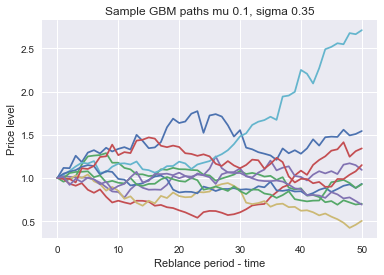

In [11]:
plot_sample_paths(S, mu, sigma)

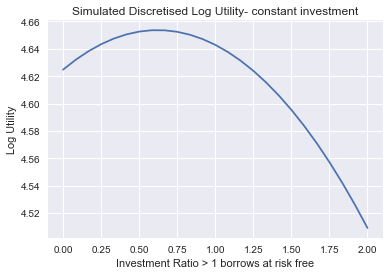

In [12]:
plot_disc_utility(u_star,utility)

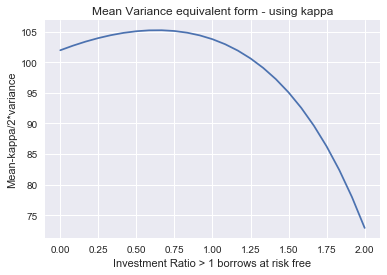

In [13]:
plot_mv_equiv(u_star, vals)

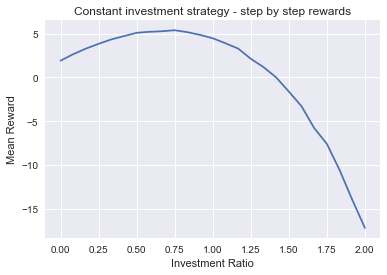

In [14]:
plot_const_step(u_star,mean_rewards)

In [15]:
#####be sure to calibrate kappa in the same way as the training for the agent
#kappa = 0.006

#run the various baseline graphs pre agent
utilities_test_rand, rewards_test_rand, step_rew_rand, wealth_test_rand = execute_strat(kappa,mu, rf, sigma, utes,u_star,best_action, 'Random', 
                                                                      time_periods=time_periods, wealth=wealth)
utilities_test_best, rewards_test_best, step_rew_best, wealth_test_best = execute_strat(kappa, mu, rf, sigma, utes, u_star, best_action,'Merton', 
                                                                      time_periods=time_periods, wealth=wealth)

#block_utilities_test_rand = np.mean(np.array(utilities_test_rand).reshape(1000,-1),0)
#block_utilities_test_best = np.mean(np.array(utilities_test_best).reshape(1000,-1),0)

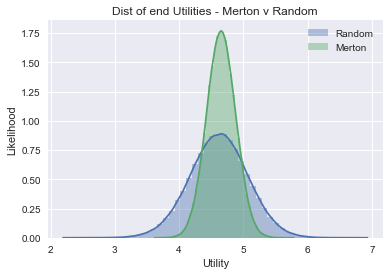

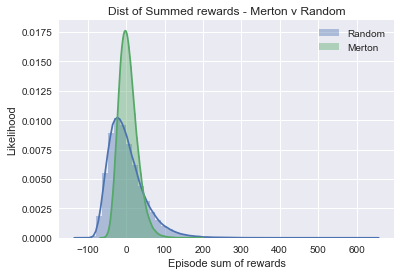

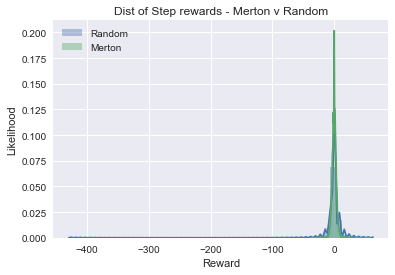

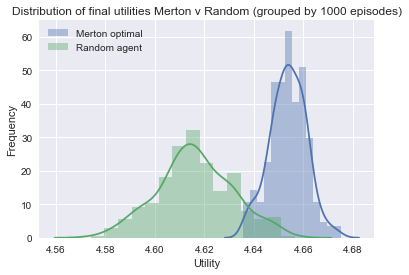

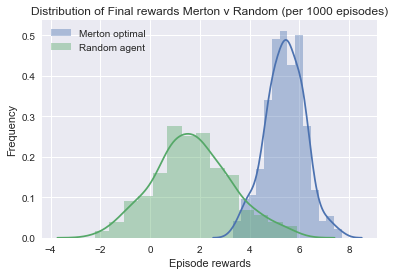

In [16]:
make_baseline_graphs(utilities_test_rand,utilities_test_best,
                         rewards_test_rand,rewards_test_best, step_rew_rand, step_rew_best)

LogUtestudt-doubles7epi3000000er0kappa8.0.npy


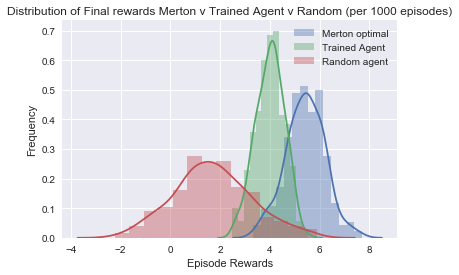

../lib/graphs.py:134: MatplotlibDeprecationWarning: The set_axis_bgcolor function was deprecated in version 2.0. Use set_facecolor instead.
  ax.set_axis_bgcolor('white')


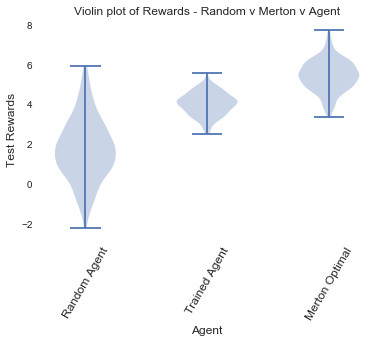

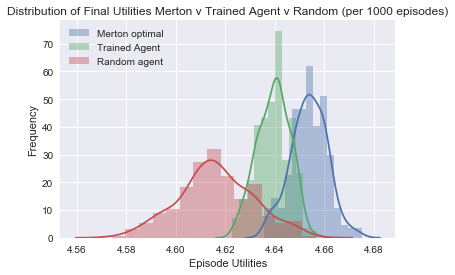

../lib/graphs.py:154: MatplotlibDeprecationWarning: The set_axis_bgcolor function was deprecated in version 2.0. Use set_facecolor instead.
  ax.set_axis_bgcolor('white')


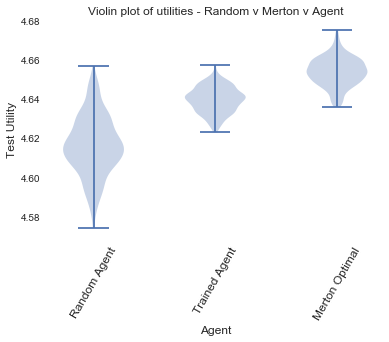

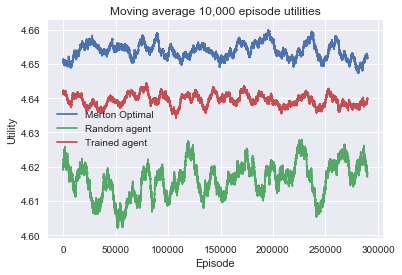

../lib/graphs.py:173: MatplotlibDeprecationWarning: The set_axis_bgcolor function was deprecated in version 2.0. Use set_facecolor instead.
  ax.set_axis_bgcolor('white')


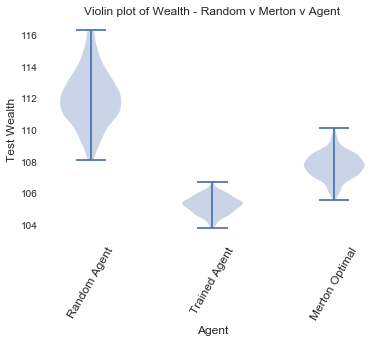

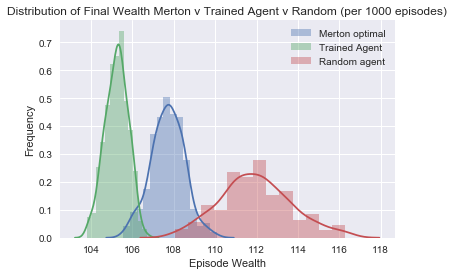

../lib/graphs.py:193: MatplotlibDeprecationWarning: The set_axis_bgcolor function was deprecated in version 2.0. Use set_facecolor instead.
  ax.set_axis_bgcolor('white')


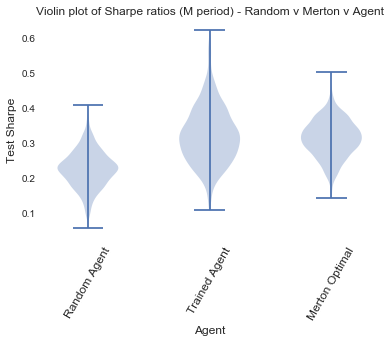

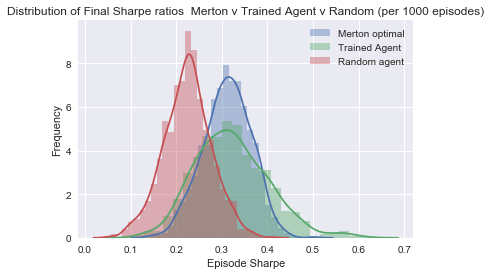

In [26]:
#Now with the trained agent
import os
path = '/Users/johngoodacre/Desktop/RLMerton/rl/td/q_tables/models'
files = os.listdir(path)

#Q = np.load('q_tables/prior_runs/best_q_so_far.npy')
#Q = np.load('q_tables/models/2epi3000000er8.npy')

#for file in files:
#    Q = np.load(path+'/'+file)
#    print(file)

#Q = np.load('q_tables/models/Noisy2epi3000000er8kappa1.0.npy') = this gave some v nice results...
#Q = np.load('q_tables/models/Noisy2epi3000000er8kappa2.0.npy') and this was very bad??
#Q = np.load('q_tables/models/Noisy2epi3000000er8kappa3.0.npy') this looked good also
#Q = np.load('q_tables/models/Noisy2epi3000000er8kappa4.0.npy') very strong


#Q = np.load('q_tables/models/Noisy2epi3000000er8kappa9.0.npy') not so convincing
#Q = np.load('q_tables/models/Noisy2epi3000000er8kappa10.0.npy') bad
#Q = np.load('q_tables/models/Noisy2epi3000000er8kappa11.0.npy') not great
#Q = np.load('q_tables/models/Noisy2epi3000000er8kappa13.0.npy') good risk averse

#Q = np.load('q_tables/models/LowVol2epi3000000er8kappa0.0.npy') #this is good...risk neutrality demo
#Q = np.load('q_tables/models/LowVol2epi3000000er8kappa9.0.npy') not convincing
#Q = np.load('q_tables/models/LogUteLowVol2epi3000000er8kappa8.0.npy') using utes - looks good

#LogUteNoisy1epi3000000er8kappa0.0.npy velly nice


#Q = np.load('q_tables/models/LogUteNoisy1epi3000000er8kappa1.0.npy') #this works


#path = '/Users/johngoodacre/Desktop/RLMerton/rl/td/q_tables/models'
#files = os.listdir(path)

results = []

#Q = np.load('q_tables/diffmodels/LogUteNoisy1epi3000000er8kappa1.0.npy')
#Q = np.load('q_tables/diffmodels/LogUteNoisy3epi3000000er8kappa130.0.npy')


path = '/Users/johngoodacre/Desktop/RLMerton/rl/td/q_tables/diffmodels/'
files = os.listdir(path)


for file in files:
    if 'LogUtestudt-doubles7epi3000000er0kappa8.0' in file:
        print(file)

        Q = np.load(path+'/'+file)
        utilities_test, rewards_test, step_rew_test, wealth_test = execute_strat(kappa, mu, rf, sigma, utes, 
                                        u_star,best_action, 'Agent', q_values=Q, 
                                        time_periods=time_periods, wealth=wealth)


        res = make_agent_graphs(rewards_test_best, rewards_test_rand, rewards_test,
              utilities_test_best, utilities_test_rand, utilities_test,
             wealth_test_rand, wealth_test_best, wealth_test)
        results.append(res)

In [23]:
for r in res:
    print(np.std(r))
    #print(np.mean(r)+np.log(100))

0.01504153794106459
0.008375760609067076
0.007338186174506179
1.5482693668579786
0.8581476357457483
0.7847633780647411
1.7195743189599384
0.8663545502531861
0.8041508240504577
0.05221615562060215
0.060178961907056364
0.052671581207038104
